In [1]:
from keras.applications import VGG16
from keras import backend as K

In [3]:
model = VGG16(weights = 'imagenet', include_top = False)
layer_name = 'block3_conv1'
filter_index = 0

#한 필터 값을 최대화하는 손실 함수를 정의(ex block3_conv1 층 필터 0번의 활성화를 손실로 정의)
#활성화 값을 최대화하기 위해 입력 이미지를 변경하도록

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:,filter_index])

In [4]:
grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)

In [5]:
iterate = K.function([model.input], [loss,grads])

import numpy as np

loss_value, grads_value = iterate([np.zeros((1,150,150,3))])

In [6]:
input_img_data = np.random.random((1,150,150,3))*20+128.

step = 1
for i in range(40) :
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value*step

In [7]:
#tensor to image

def deprocess_image(x) :
    x-= x.mean()
    x/=(x.std() + 1e-5)
    x*=0.1
    
    x+=0.5
    x = np.clip(x,0,1)
    
    x*=255
    x = np.clip(x,0,255).astype('uint8')
    
    return x

In [8]:
def generate_pattern(layer_name, filter_index, size=150):
    # 주어진 층과 필터의 활성화를 최대화하기 위한 손실 함수를 정의합니다
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # 손실에 대한 입력 이미지의 그래디언트를 계산합니다
    grads = K.gradients(loss, model.input)[0]

    # 그래디언트 정규화
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # 입력 이미지에 대한 손실과 그래디언트를 반환합니다
    iterate = K.function([model.input], [loss, grads])
    
    # 잡음이 섞인 회색 이미지로 시작합니다
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 경사 상승법을 40 단계 실행합니다
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

In [10]:
import matplotlib.pyplot as plt

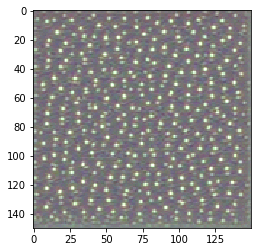

In [11]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

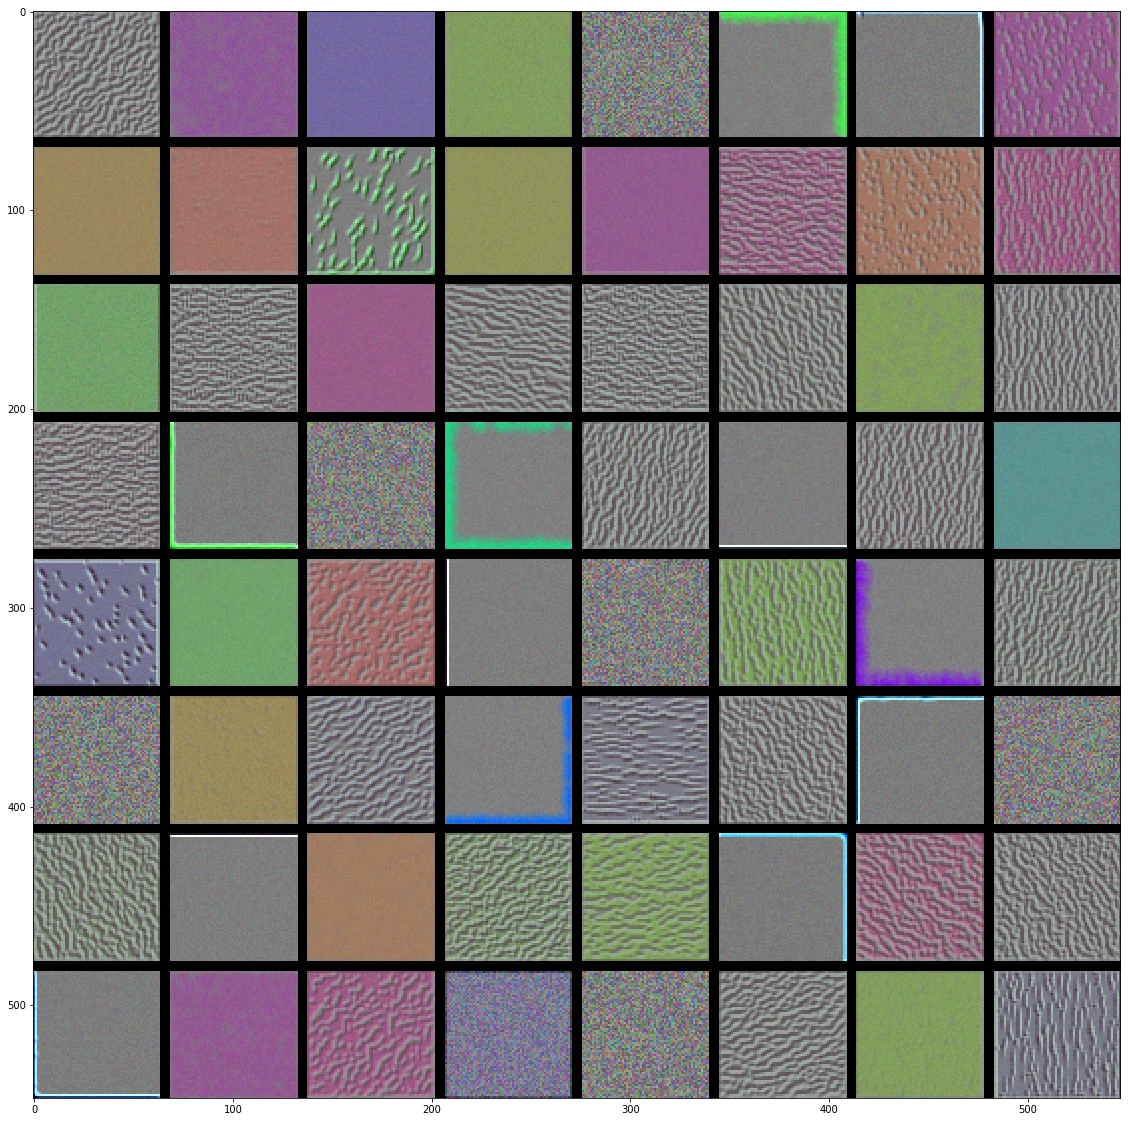

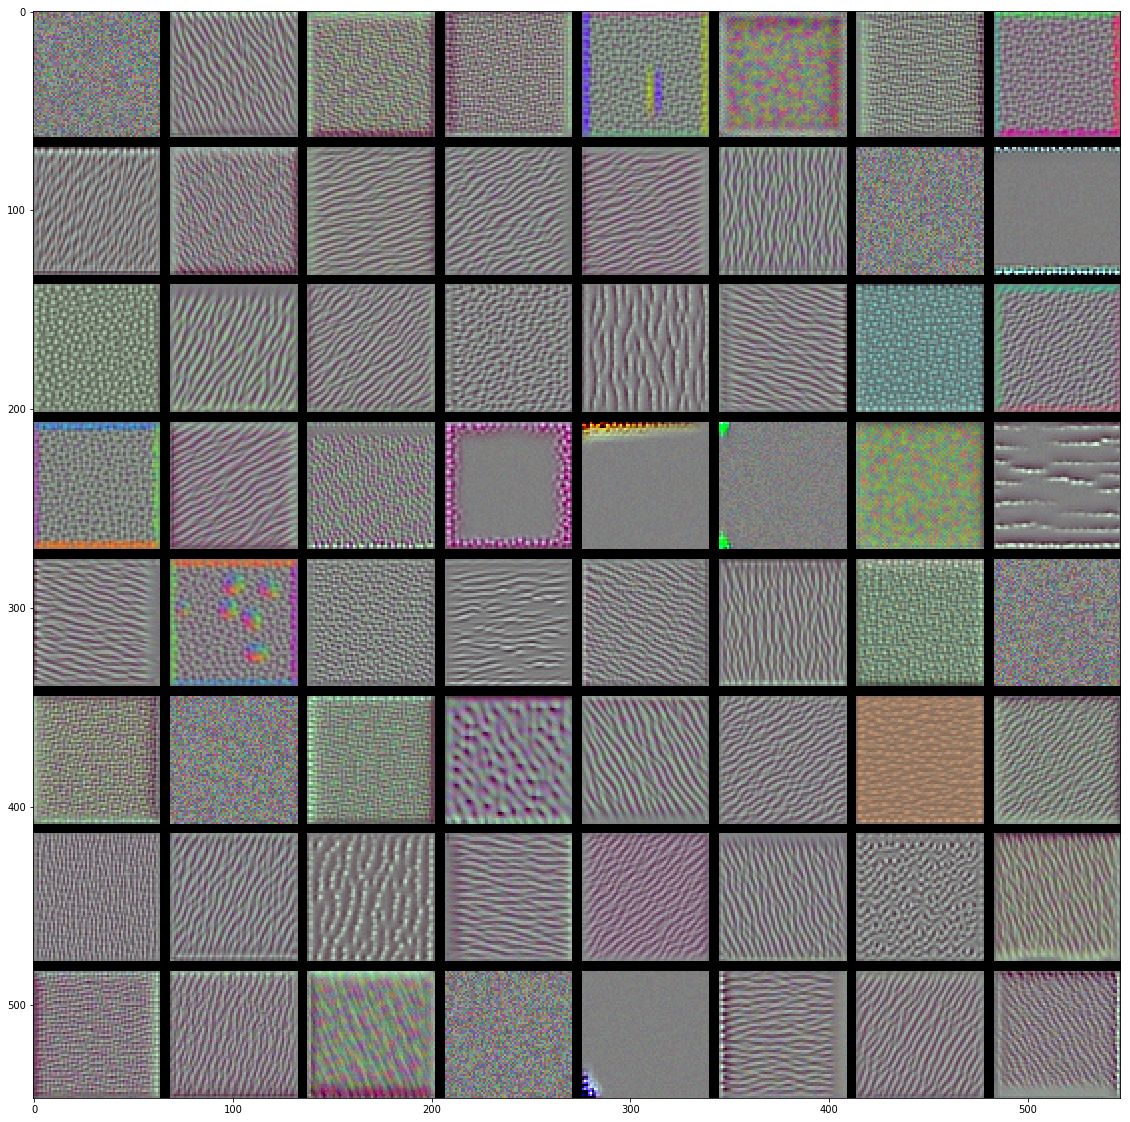

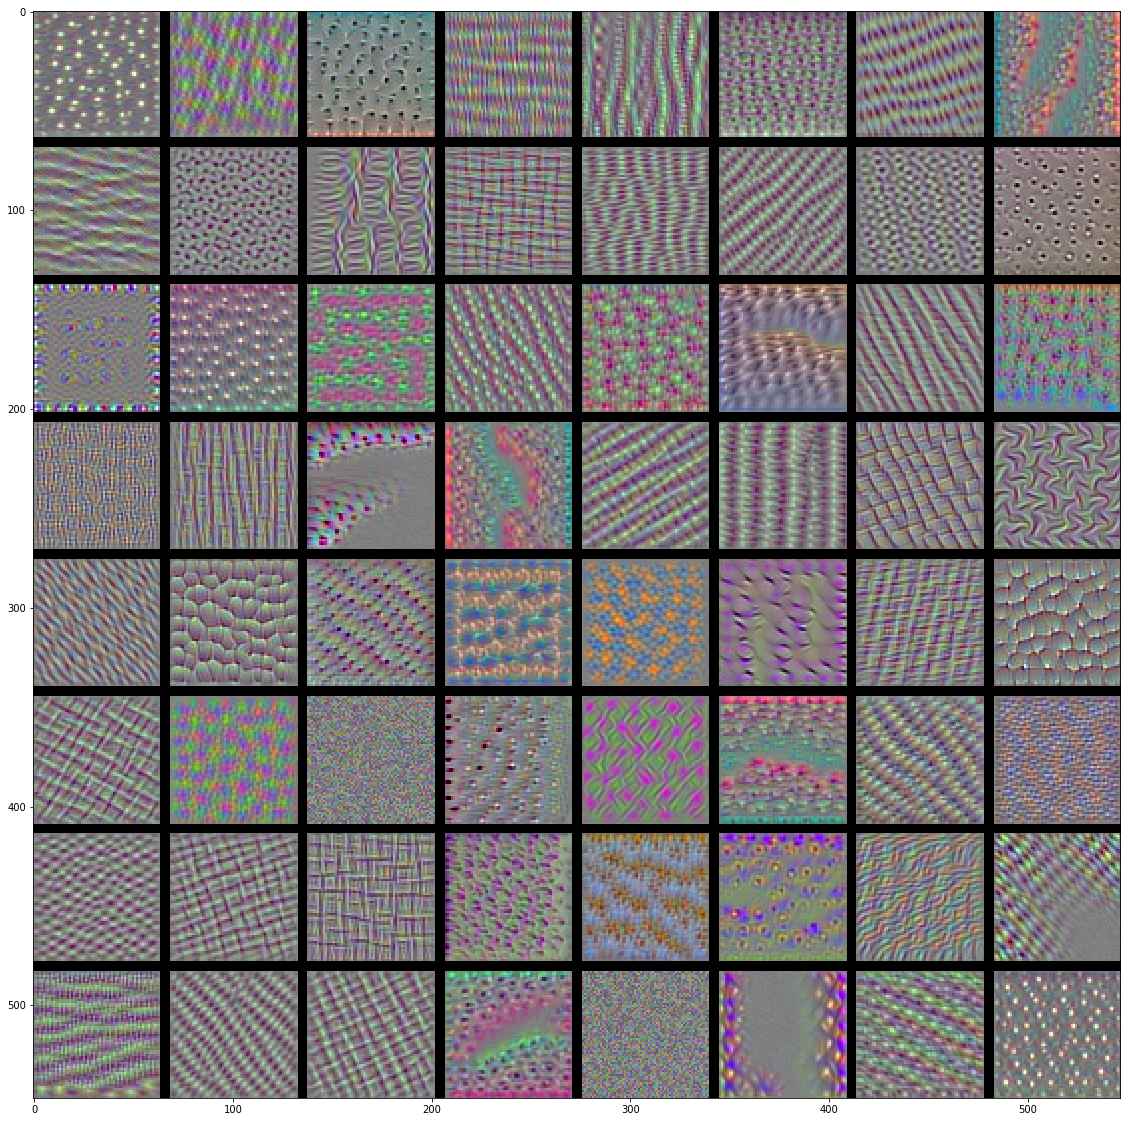

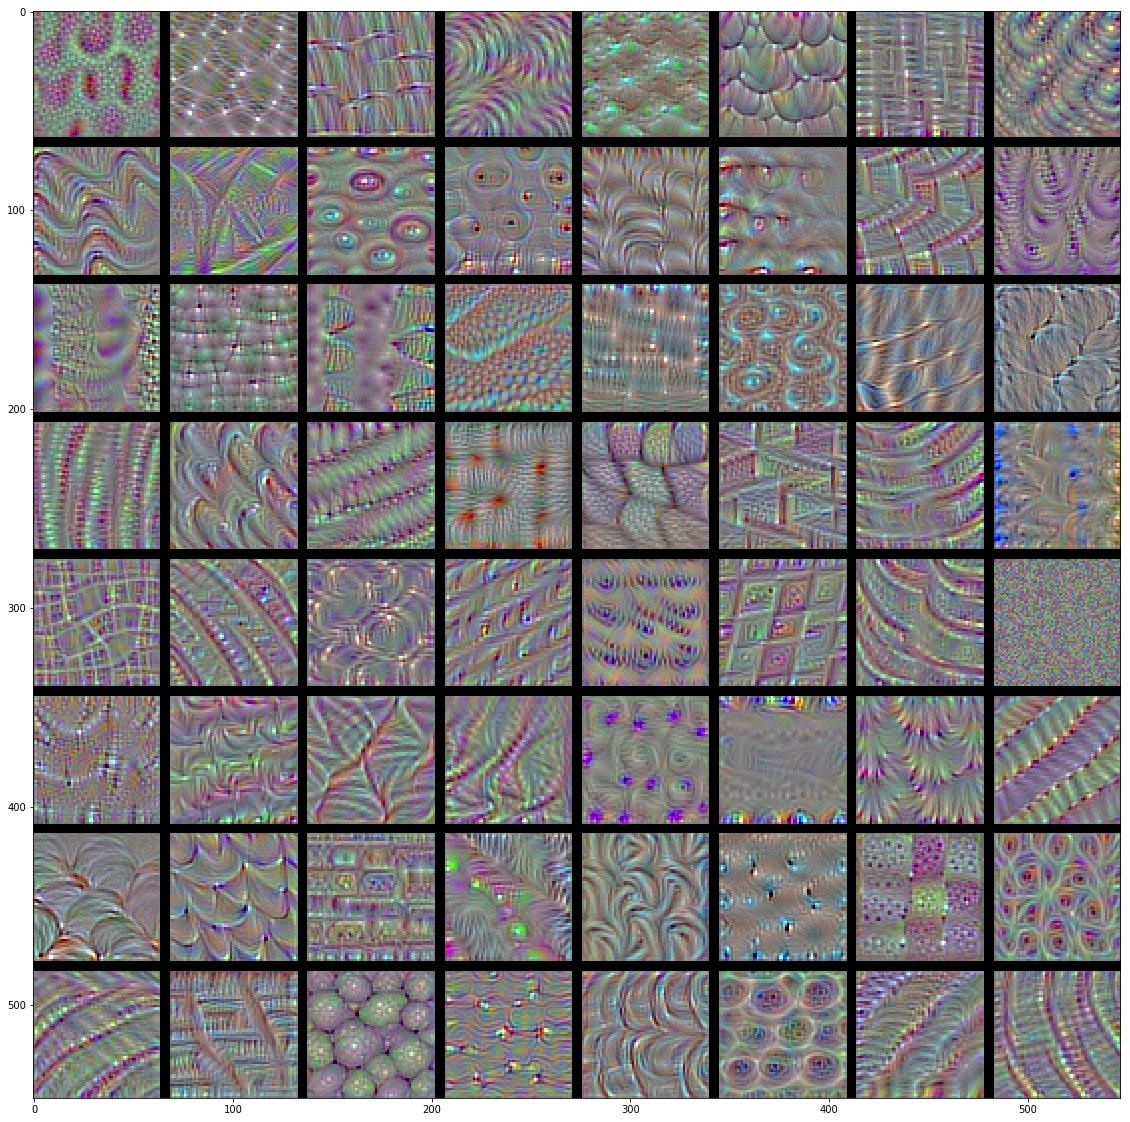

In [13]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # 결과를 담을 빈 (검은) 이미지
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')

    for i in range(8):  # results 그리드의 행을 반복합니다
        for j in range(8):  # results 그리드의 열을 반복합니다
            # layer_name에 있는 i + (j * 8)번째 필터에 대한 패턴 생성합니다
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # results 그리드의 (i, j) 번째 위치에 저장합니다
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # results 그리드를 그립니다
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()